# Traditional Machine Learning on hemorrhage classification

Compare the classification performance of Logisitic Regression, LDA, QDA, Random Forest Classifier, and SVM.

It's imbalanced image dataset, we use **oversampling** skill here.


### Preparing the Data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
# Read hemorrhage label file
labels = pd.read_csv("~/Downloads/BrainCTScan/new_hemorrhage_label.csv")
display(labels.head())


,Image,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,normal
0,ID_48c9c3858.jpg,0,1,0,0,0,0
1,ID_79d8e9cd1.jpg,0,0,0,1,0,0
2,ID_6b2f0cf23.jpg,0,0,0,1,0,0
3,ID_2bcec32fd.jpg,0,1,0,0,0,0
4,ID_13a645629.jpg,0,1,0,0,0,0


In [3]:
# Convert from one-hot encoding format to label encoding
hemorrhage_types = labels.drop(columns=['Image'])
hemorrhage_types = pd.get_dummies(hemorrhage_types).idxmax(1)
hemorrhage_types.head(10)

0    intraparenchymal
1        subarachnoid
2        subarachnoid
3    intraparenchymal
4    intraparenchymal
5              normal
6    intraventricular
7        subarachnoid
8    intraparenchymal
9    intraventricular
dtype: object

In [4]:
from sklearn.preprocessing import LabelEncoder

# Target y one-hot encoded target variable (DataFrame)
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(hemorrhage_types)
y_encoded

array([1, 4, 4, ..., 1, 4, 1])

In [5]:
# Get the unique classes and their corresponding numerical labels
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Display the class mapping
print("Class Mapping:")
for class_name, label in class_mapping.items():
    print(f"{class_name}: {label}")



Class Mapping:
epidural: 0
intraparenchymal: 1
intraventricular: 2
normal: 3
subarachnoid: 4
subdural: 5


In [6]:
labels['y_encoded'] = y_encoded
labels.head()

,Image,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,normal,y_encoded
0,ID_48c9c3858.jpg,0,1,0,0,0,0,1
1,ID_79d8e9cd1.jpg,0,0,0,1,0,0,4
2,ID_6b2f0cf23.jpg,0,0,0,1,0,0,4
3,ID_2bcec32fd.jpg,0,1,0,0,0,0,1
4,ID_13a645629.jpg,0,1,0,0,0,0,1


In [7]:
# Class distribution
label_counts = labels['y_encoded'].value_counts()
print(label_counts)


y_encoded
1    953
2    534
3    500
4    498
5    490
0    471
Name: count, dtype: int64


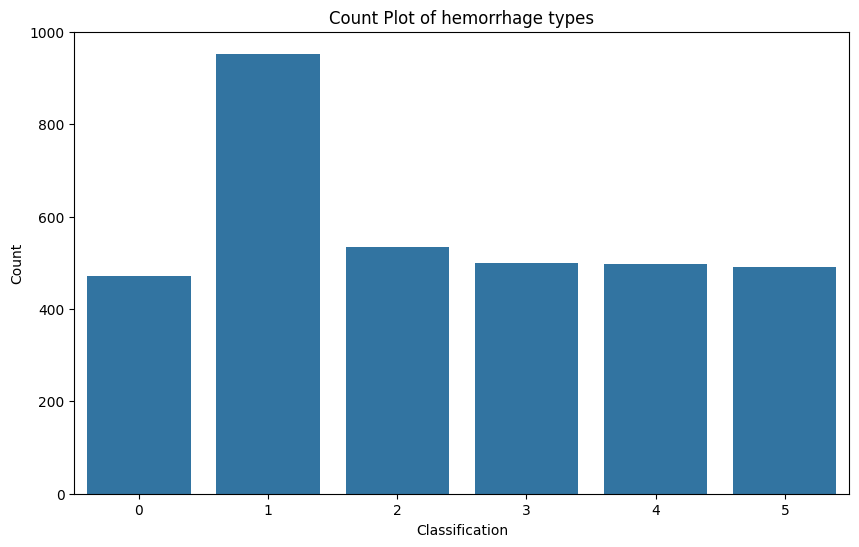

In [8]:
# Assign label_counts is the result of labels['y_encoded'].value_counts()
label_counts = labels['y_encoded'].value_counts()

# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='y_encoded', data=labels)

# Add labels and title
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Count Plot of hemorrhage types')

# Show the plot
plt.show()


It's imbalanced dataset, and type 1 has the majority of distribution. We'll use oversampling skill later.

In [9]:
from skimage.io import imread
from skimage.transform import resize

# All images stored in the "shuffled_image" folder
file_dir = "~/Downloads/BrainCTScan/shuffled_images/"

data = []

for file_name in labels.Image:
    img_array = imread(os.path.join(file_dir, file_name))
    img_resized = resize(img_array, (128, 128))
    flattened_img = img_resized.flatten()
    data.append(flattened_img)
    
# Normalize all pixels!
data = np.array(data)/255.0
df = pd.DataFrame(data)

# Add a column for the target labels
df['Target'] = y_encoded

# Display the DataFrame shape
df.shape


(3446, 16385)

In [10]:
# from imblearn.under_sampling import RandomUnderSampler # Down Sampling
from imblearn.over_sampling import RandomOverSampler # Over Sampling

# Assign X, y
X = df.drop('Target', axis=1)  # Features
y = df['Target']  # Target variable

# Instantiate the RandomUnderSampler
ros = RandomOverSampler(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create a new DataFrame with the over-sampled data
df_oversampled = pd.DataFrame(X_resampled, columns=X.columns)
df_oversampled['Target'] = y_resampled

# Display the counts of each class in the down-sampled DataFrame
print("Over-sampled Class Counts:")
print(df_oversampled['Target'].value_counts())


Over-sampled Class Counts:
Target
1    953
4    953
3    953
2    953
5    953
0    953
Name: count, dtype: int64


/var/folders/l8/b2285nqj68x2y4sdjnfwd4v80000gn/T/ipykernel_8698/2197221442.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_oversampled['Target'] = y_resampled


In [11]:
df_oversampled.shape

(5718, 16385)

In [12]:
from sklearn.model_selection import train_test_split

x=df_oversampled.iloc[:,:-1]
y=df_oversampled.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state= 0)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(4574, 16384) (1144, 16384)
(4574,) (1144,)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [38]:
# Train and evaluate Logistic Regression
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train, y_train)  # Flatten yds_train 
logistic_pred = logistic_reg.predict(x_test)

# Evaluate performance
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_report = classification_report(y_test, logistic_pred)
conf_matrix_logistic = confusion_matrix(y_test, logistic_pred)

# Print metrics
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Classification Report:\n", logistic_report)
print("Confusion Matrix:\n", conf_matrix_logistic)



Logistic Regression Accuracy: 0.30332167832167833
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.28      0.29       192
           1       0.22      0.12      0.16       194
           2       0.28      0.43      0.34       177
           3       0.42      0.59      0.49       208
           4       0.23      0.16      0.19       184
           5       0.25      0.22      0.23       189

    accuracy                           0.30      1144
   macro avg       0.28      0.30      0.28      1144
weighted avg       0.29      0.30      0.29      1144

Confusion Matrix:
 [[ 54  19  36  34  24  25]
 [ 38  24  54  25  22  31]
 [ 20  17  76  23  18  23]
 [ 19   7  26 123  10  23]
 [ 19  20  41  51  29  24]
 [ 27  23  35  40  23  41]]


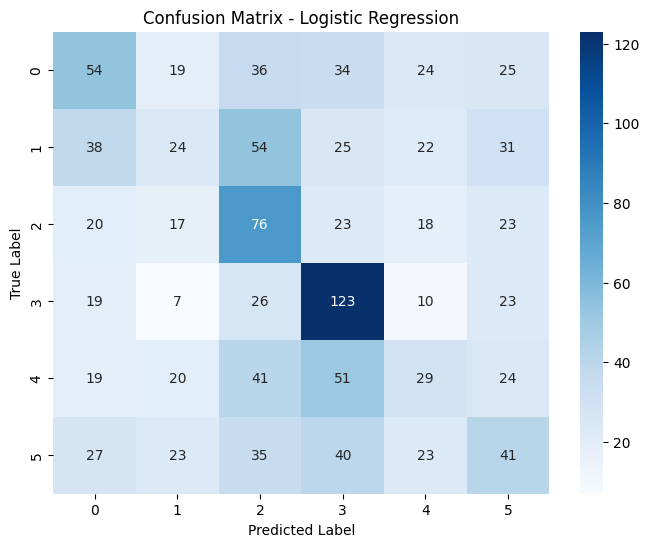

In [17]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


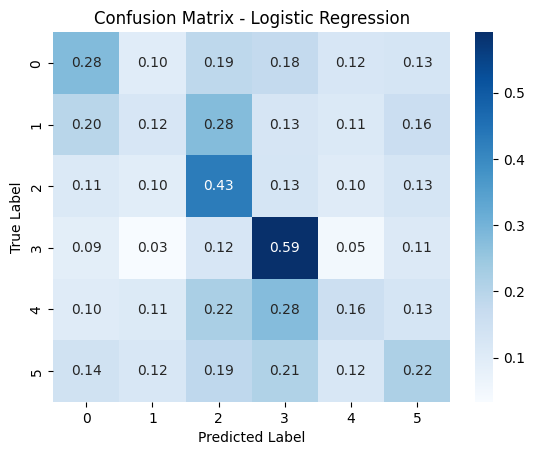

In [18]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_logistic.astype('float') / conf_matrix_logistic.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### LDA

In [19]:
# Train and evaluate LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
lda_pred = lda.predict(x_test)

# Evaluate performance
lda_accuracy = accuracy_score(y_test, lda_pred)
lda_report = classification_report(y_test, lda_pred)
conf_matrix_lda = confusion_matrix(y_test, lda_pred)

# Print metrics
print("LDA Accuracy:", lda_accuracy)
print("LDA Report:\n", lda_report)
print("Confusion Matrix:\n", conf_matrix_lda)

LDA Accuracy: 0.6354895104895105
LDA Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74       192
           1       0.43      0.37      0.40       194
           2       0.72      0.71      0.72       177
           3       0.69      0.75      0.72       208
           4       0.57      0.59      0.58       184
           5       0.62      0.67      0.64       189

    accuracy                           0.64      1144
   macro avg       0.63      0.64      0.63      1144
weighted avg       0.63      0.64      0.63      1144

Confusion Matrix:
 [[140  13   2  14  12  11]
 [ 17  71  19  27  30  30]
 [  7  19 126   5  14   6]
 [  6  14   7 155  14  12]
 [  5  27  10  14 109  19]
 [ 10  20  11  10  12 126]]


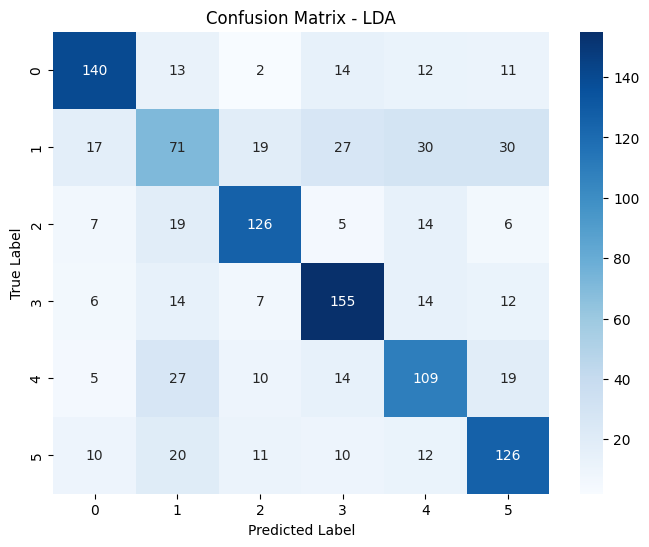

In [20]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LDA")
plt.show()

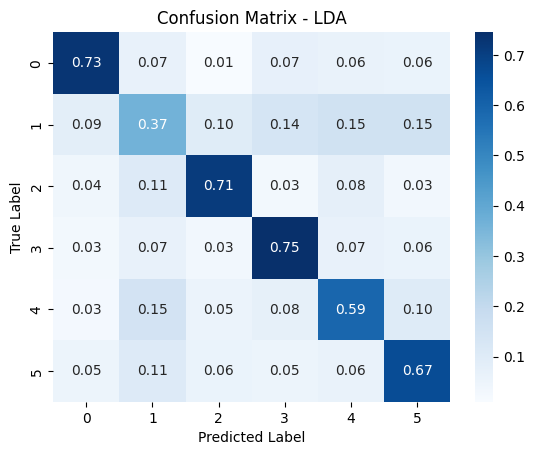

In [21]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_lda.astype('float') / conf_matrix_lda.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LDA")
plt.show()

### QDA

In [22]:
# Train and evaluate QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)
qda_pred = qda.predict(x_test)

# Evaluate performance
qda_accuracy = accuracy_score(y_test, qda_pred)
qda_report = classification_report(y_test, qda_pred)
conf_matrix_qda = confusion_matrix(y_test, qda_pred)

# Print metrics
print("QDA Accuracy:", qda_accuracy)
print("QDA Report:\n", qda_report)
print("Confusion Matrix:\n", conf_matrix_qda)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Accuracy: 0.7412587412587412
QDA Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.83       192
           1       0.40      1.00      0.57       194
           2       1.00      0.66      0.79       177
           3       1.00      0.72      0.83       208
           4       1.00      0.62      0.77       184
           5       1.00      0.74      0.85       189

    accuracy                           0.74      1144
   macro avg       0.90      0.74      0.77      1144
weighted avg       0.90      0.74      0.77      1144

Confusion Matrix:
 [[135  57   0   0   0   0]
 [  0 194   0   0   0   0]
 [  0  61 116   0   0   0]
 [  0  59   0 149   0   0]
 [  0  69   0   0 115   0]
 [  0  50   0   0   0 139]]


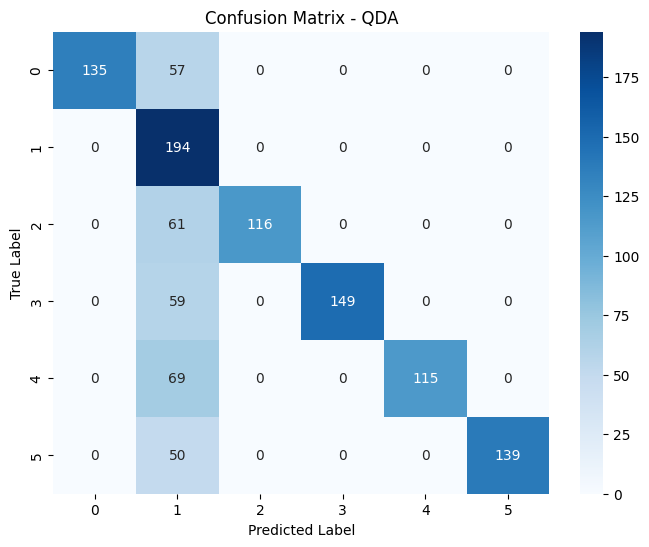

In [23]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - QDA")
plt.show()

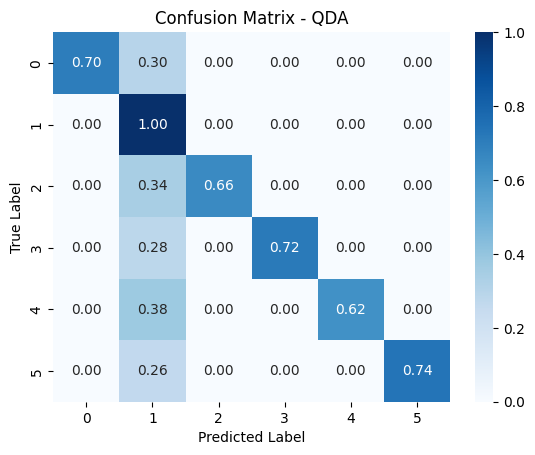

In [24]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_qda.astype('float') / conf_matrix_qda.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - QDA")
plt.show()

### Random Forest Classification

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
rf_classifier.fit(x_train, y_train)

# Predict probabilities for each class
rf_pred = rf_classifier.predict(x_test)

# Evaluate performance
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)
conf_matrix_rf = confusion_matrix(y_test, rf_pred)

# Print or use the evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Report:\n", rf_report)
print("Confusion Matrix:\n", conf_matrix_rf)


Random Forest Accuracy: 0.7622377622377622
Random Forest Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       192
           1       0.58      0.48      0.53       194
           2       0.76      0.86      0.80       177
           3       0.83      0.87      0.85       208
           4       0.85      0.68      0.76       184
           5       0.73      0.82      0.78       189

    accuracy                           0.76      1144
   macro avg       0.76      0.76      0.76      1144
weighted avg       0.76      0.76      0.76      1144

Confusion Matrix:
 [[165  10   3   4   0  10]
 [ 22  94  29  12  12  25]
 [  7  15 152   1   2   0]
 [  3  12   3 180   4   6]
 [  2  21   7  13 126  15]
 [  7  10   7   6   4 155]]


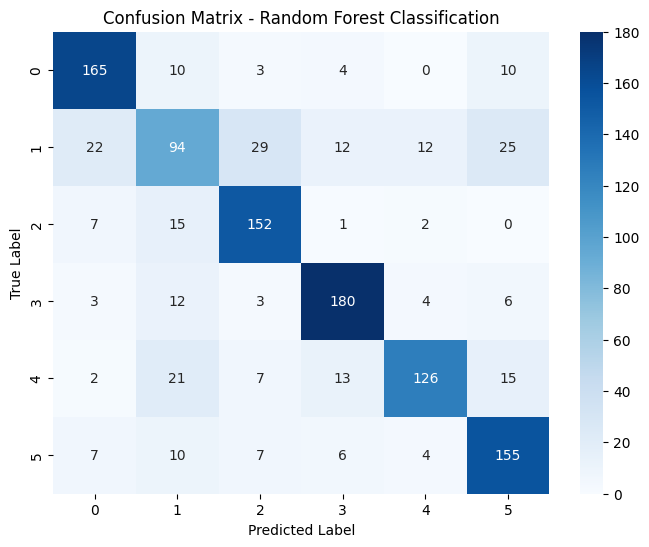

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Classification")
plt.show()

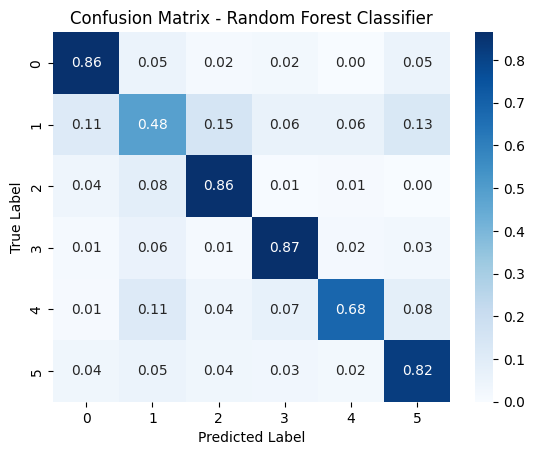

In [27]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_rf.astype('float') / conf_matrix_rf.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

### SVM (Support Vector Machine)

In [18]:
#Can also use SVM but RF is faster and may be more accurate.
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

# Predict probabilities for each class
SVM_pred = SVM_model.predict(x_test)

# Evaluate performance
SVM_accuracy = accuracy_score(y_test, SVM_pred)
SVM_report = classification_report(y_test, SVM_pred)
conf_matrix_SVM = confusion_matrix(y_test, SVM_pred)

# Print or use the evaluation metrics
print("SVM Accuracy:", SVM_accuracy)
print("SVM Report:\n", SVM_report)
print("Confusion Matrix:\n", conf_matrix_SVM)

SVM Accuracy: 0.5515734265734266
SVM Report:
               precision    recall  f1-score   support

           0       0.58      0.74      0.65       192
           1       0.35      0.28      0.31       194
           2       0.57      0.68      0.62       177
           3       0.72      0.67      0.69       208
           4       0.49      0.44      0.46       184
           5       0.56      0.49      0.52       189

    accuracy                           0.55      1144
   macro avg       0.54      0.55      0.54      1144
weighted avg       0.54      0.55      0.54      1144

Confusion Matrix:
 [[142   6   5  10  19  10]
 [ 29  55  39  13  27  31]
 [ 12  30 120   3   6   6]
 [ 19  16   6 140  19   8]
 [ 14  24  24  22  81  19]
 [ 28  28  18   7  15  93]]


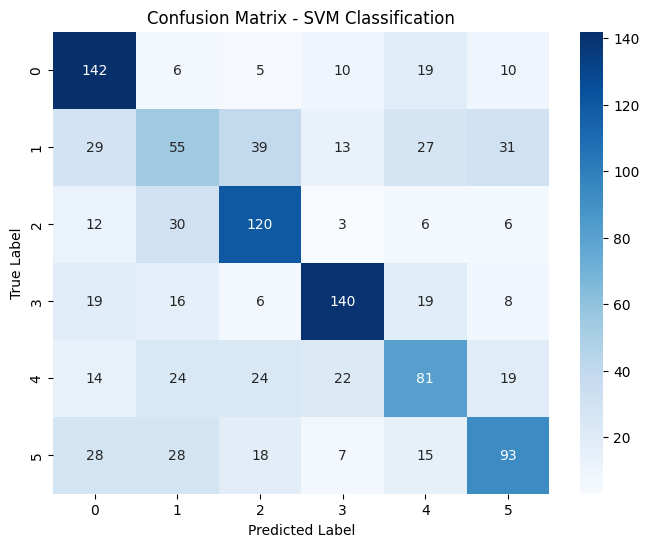

In [16]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_SVM, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Classification")
plt.show()

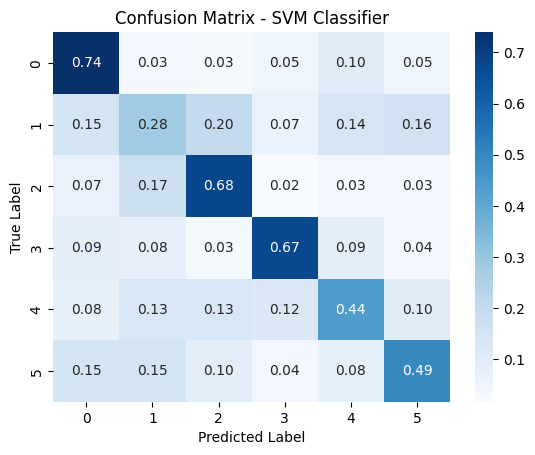

In [17]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_SVM.astype('float') / conf_matrix_SVM.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Classifier")
plt.show()